In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step-1

# Reading and Utilizing Provided Data

In [2]:
patient_data=pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [3]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


* Here we have Patient Ids and Disease info
  

> Lets check out what is in annoted '.txt' files of audio files.

In [4]:
df=pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t')
df.head()

,1.862,5.718,0,1
0,5.718,9.725,1,1
1,9.725,13.614,0,1
2,13.614,17.671,0,1
3,17.671,19.541,0,0


* These are very usefull information namely (Start , End ( time of respiratory cycles) ,crackles,weezels)

> So lets get them into a dataset

> Note:- i use sep **' \t '** cause we are reading data from text file which is sperated by tabs here

In [5]:
import os
path='/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['160_1b3_Al_mc_AKGC417L',
 '146_2b2_Pl_mc_AKGC417L',
 '130_2b2_Ll_mc_AKGC417L',
 '159_1b1_Pr_sc_Meditron',
 '130_1p4_Tc_mc_AKGC417L']

> As mentioned in **filename_format.txt** , '.txt' files of annotated audio files have various information. So we will try to extract that too.  

In [6]:
def getFilenameInfo(file):
    return file.split('_')

In [7]:
getFilenameInfo('160_1b3_Al_mc_AKGC417L')

['160', '1b3', 'Al', 'mc', 'AKGC417L']

> Here useful info  is [Patient ID, __ ,__ ,Type(mono,stereo), __ ]

In [8]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L


> Now we can join both **patient_data** and **files_df**

In [9]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [10]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 6
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


> Lets get **pid** and **101** to same type and merge both dataframes on pid

In [11]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

In [12]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L,COPD


In [13]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

# Step 2 

# Processing Audio files

> Now we only want that parts from whole audio file which contains **Respiratory Cycles** 

> We can do this by utilizing the start and end time specifiles for these cycles in our **data dataframe**

In [14]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

* we multiplied start with sampling rate cause start is time and raw_data is array sampled acc. to sampling rate

> Now we also want our input images to our cnn to be of same size for that audio files must be of **same length** i.e **(start - end)** must be same 

> Lets find the best length we can have

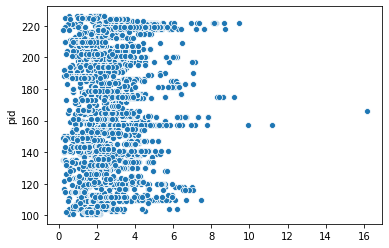

In [15]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

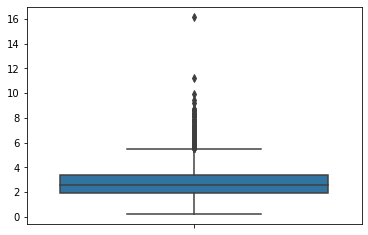

In [16]:
sns.boxplot(y=(data.end-data.start))

> From these plots we can conclude that best length is **~6**

> Also if difference is <6 we must **Zero Pad** it to get it to required length

> Zero Padding means **silent**


> Lets create a directory for storing our files

In [17]:
os.makedirs('processed_audio_files')

* We can iterate over dataset using iterrows, its output is as shown

In [18]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        1.862
end                          5.718
crackles                         0
weezels                          1
pid                            160
mode                            mc
filename    160_1b3_Al_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object


> Also a single sample of audio file can have **Many Respiratory Cycles** so we might have to same multiple files for a simple audio file

> I will be using **Librosa** module for loading audio files and **Soundfile** module for writing to output path

> **Study The following Function Carefully**

In [19]:
import librosa as lb
import soundfile as sf
i,c=0,0
for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc=path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path='processed_audio_files/' + filename
    c+=1
    
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

Total Files Processed:  6898
